## <b>Problem Statement</b>

ABC Inc is a US based specialty retailer of crafts and fabrics. ABC Inc wants to predict the sales of their products based on historic sales. They already have a forecasting system in place, but its accuracy is low.  Sales forecast will feed into the budget planning and hence needs to have good accuracy. As an analytics consultant, ABC Inc have approached you to build a forecasting system with good accuracy.	

The retailer runs promotions at different parts of the year with an expectation to increase the margin. Given the daily sales data for 2017, 2018 and 2019 at Product level and the Promotion Calendar, you need to predict the sales of the products for the time-period: **1st Jan’2020 to 31st March’2020**


### Datasets
1.	Sales Data – Sales data at day level with promotions on each day
2.	Promotion Calendar – Promotion calendar for the future period
3.	Product Master – Product hierarchy along with the Unit Retail Price of the product


<b>There are 3 types of offers, which are given as P, F, and A.</b>

1. P (Percentage offer) : x% offer on the Unit Retail Price (Unit Retail Price is same as MRP)
2. F (Fixed offer) : Buy a product for $9.99. Regardless of the URP of the product, customer will get it for $9.99. For instance, if URP is $24.99, amount customer has to pay after promotion will be $9.99
3. A (Amount offer) : Buy a product for $9.99 off. This means that customer will get a discount of $9.99 on the URP. For instance, if URP is $24.99, amount customer has to pay after promotion will be $15

## <b>Questions for Business / Data Understanding:</b>
1.	Detect the outliers in the quantity and apply an outlier treatment on the same. Specify the outlier treatment technique and reason for choosing the same
2.	Check the data for missing values and apply the missing value treatment. Also provide the reasoning for the missing value treatment method used
3.	Check for seasonality and trend effect and smoothen if needed
4.	Results of EDA performed, if any
5.	Fit a model to predict the quantity from 1st Jan 2020 to 31st Mar 2020
6.	Evaluate your model performance


In [264]:
# Import the libraries
import pandas as pd
import numpy as np
import math
import re
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_absolute_percentage_error


In [265]:
# TS Models to test
from prophet import Prophet
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt


In [266]:
sales = pd.read_csv("Sales data.csv")
product = pd.read_excel("Product Master.xlsx")
promotion = pd.read_excel("Promotion Master.xlsx")

In [267]:
sales.Product.nunique()

197

In [268]:
# Merge Sales and Product data
sales_data = sales.merge(product, on = 'Product', how='left')

# Changing Qualtity to int with cealing as quantity cannot be a float
sales_data.Quantity = sales_data.Quantity.apply(lambda x : math.ceil(x))

# Updating the datatype
sales_data.OfferType = sales_data.OfferType.astype('str')
sales_data.Date = pd.to_datetime(sales_data.Date)

In [269]:
# Method to calculate retail price after promotion

def retail_price_after_promotion(df):
    df['Promo_UnitRetailPrice'] = ''
    for idx in df.index:
        if (df['OfferType'][idx] != 'nan'):  
            val = float((re.findall(r'\d+\.?\d*', df['Offer'][idx])).pop())
            #df['preoce'][idx] = val

            if (df['OfferType'][idx] == 'P'):
                df['Promo_UnitRetailPrice'][idx] = df['UnitRetailPrice'][idx] * (100-val)/100
            elif (df['OfferType'][idx] == 'F'):
                df['Promo_UnitRetailPrice'][idx] = val
            else:
                df['Promo_UnitRetailPrice'][idx] = df['UnitRetailPrice'][idx] - val
        else:
            df['Promo_UnitRetailPrice'][idx] = df['UnitRetailPrice'][idx]


retail_price_after_promotion(sales_data)


<ipython-input-269-f90150879dd4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Promo_UnitRetailPrice'][idx] = df['UnitRetailPrice'][idx]
<ipython-input-269-f90150879dd4>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Promo_UnitRetailPrice'][idx] = val
<ipython-input-269-f90150879dd4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Promo_UnitRetailPrice'][idx] = df['UnitRetailPrice'][idx] * (100-val)/100
<ipython-in

In [270]:
sales_data_promo = sales_data.copy()

# EDA

#### <b>4. Results of EDA performed, if any </b>

Created an aggregated DF to understand the gap in Product series. This will help us later for data cleaning and imputing

In [271]:
# Checking products that have missing values. 
agg_data = sales_data_promo.groupby('Product').agg({'Date': ['min', 'max'], 'Product':'count'})
agg_data = agg_data.droplevel(0, axis=1)

agg_data['date_diff'] = (agg_data['max'] - agg_data['min']).dt.days + 1
agg_data['missing_data'] = agg_data['date_diff'] - agg_data['count'] 
agg_data['missing_data_percent'] = round((agg_data['missing_data']*100 / agg_data['count']), 2)

# Checking the aggregate data based on last 6 months
agg_data_6_months = sales_data_promo[sales_data_promo['Date'] > "2019-06-30"].groupby('Product').agg({'Product':'count'})
agg_data_6_months.rename({'Product':'count_in_last_6_months'}, axis=1, inplace=True)

agg_data = agg_data.merge(agg_data_6_months, on='Product', how='left')

In [272]:
agg_data.head()

,min,max,count,date_diff,missing_data,missing_data_percent,count_in_last_6_months
Product,,,,,,,
Product 1,2017-01-01,2019-12-31,1086,1095,9,0.83,182.0
Product 10,2017-01-01,2019-12-31,1086,1095,9,0.83,182.0
Product 100,2017-01-01,2019-12-31,1086,1095,9,0.83,182.0
Product 101,2017-04-24,2019-12-31,974,982,8,0.82,182.0
Product 102,2017-04-26,2019-12-31,972,980,8,0.82,182.0


## Data Cleaning / Outlier Treatment

#### <b>1. Detect the outliers in the quantity and apply an outlier treatment on the same. Specify the outlier treatment technique and reason for choosing the same </b>

1. Any product which has not being sold for last 6 month, can be dropped from prediction.
2. Any product where total days of sales is less than 90 as we would like to predict for next 90 days and having at least 1 cycle worth of actual data is necessary to create model. Also to ensure that we are not missing any product that recently got active, we will ensure that we have not seen the product >30 times during last 6 months.

Here, ideally the aim is to 'save' as many products as possible for forecasting. We will only drop extreme values


In [273]:
# Any product which has not being sold for last 6 month, can be dropped from prediction.
obselete_product = agg_data[agg_data['max'] < "2019-06-30"].index
clean_agg_data = agg_data[~agg_data.index.isin(obselete_product)]

# Any product where total days of sales is less than 90 as we would like to predict for next 90 days and having at least 1 cycle worth of actual data is necessary to create model. 
# Also to ensure that we are not missing any product that recently got active, we will ensure that we have not seen the product >30 times during last 6 months.
unusable_products = agg_data[(agg_data['count'] <= 90) & (agg_data.count_in_last_6_months <=20)].index
clean_agg_data = clean_agg_data[~clean_agg_data.index.isin(unusable_products)]

# Removing obselete/unused Products
cleaned_sales_data = sales_data_promo[sales_data_promo.Product.isin(clean_agg_data.index)]

## Imputing Missing Data

#### <b>2. Check the data for missing values and apply the missing value treatment. Also provide the reasoning for the missing value treatment method used </b>

Imputing the missing data using backfill. Most of timeseries models don't work well with missing data, so its important to impute.

In [274]:
def date_impute(product_list, df, agg_df):
    imputed_df = pd.DataFrame([])
    for i in product_list:

        starts = agg_df[agg_df.index == i]['min'].to_list().pop()
        # Max date needs to be same as we will need help to predict future dates
        #ends = agg_df[agg_df.index == i]['max'].to_list().pop()
        ends = '2019-12-31'
        full_range = pd.date_range(start = starts, end = ends, freq='D')

        test_df = df[df.Product == i].set_index('Date') 
        test_df = test_df.reindex(full_range)
        test_df = test_df.fillna(method = 'ffill')

        imputed_df = imputed_df.append(test_df)
    return imputed_df

In [275]:
cleaned_sales_data_impute = date_impute(cleaned_sales_data.Product.unique(), cleaned_sales_data, clean_agg_data)

# Reset Index
cleaned_sales_data_impute = cleaned_sales_data_impute.reset_index().rename({'index':'Date'}, axis=1)

In [276]:
# Create ranking of products to idenitfy which products to concentrate on
Product_Rank = cleaned_sales_data_impute.groupby(['Product']).agg({'Quantity':'sum'}).sort_values('Quantity', ascending=False).reset_index().reset_index().rename({'index': 'Product_Rank', 'Quantity':'Total_product_quantity'}, axis=1)

cleaned_sales_data_impute = cleaned_sales_data_impute.merge(Product_Rank, on='Product', how='left')

## Model Fitting and Evaluation

I'm using FB Prophet model here as it internally takes care of stationarity. Its a good model to use when dealing with multiple models as it has multiple hyperparameters that can be tuned.

Things to do if we are building full model:
1. Check for stationarity of time-series.
2. Start with simpler models like Arima, Sarima before utilizing complex models like Prophet or LSTM
3. Check for bias variance tradeoff. One way we can check it is by comparing training and testing error. If testing error is too high as compared to training error, then there are chances of overfitting the model.
4. Here I have used a simple Prophet model. For such complex model, its worth using grid search to identify best performing hyper-parameters
5. We can also include exogeneous variables in the model like holiday data, promotion data etc.
6. We can also create clusters of Product based on behaviour.


In [277]:
def model_selection(product_list, df):

    # Diving data into Test_Train. I'm using last 6 months data for testing.
    train_df = df[df.Date <= '2019-06-30'][["Product","Date", "Quantity"]].rename({'Date':'ds', 'Quantity':'y'}, axis=1)
    test_df = df[df.Date > '2019-06-30'][["Product","Date", "Quantity"]].rename({'Date':'ds', 'Quantity':'y'}, axis=1)
    #model_trained_data = pd.DataFrame([])
    model_test_data = pd.DataFrame([])  
    mape_list = pd.DataFrame([])  
    mape_test = 0

    for i in product_list:
        temp_train_data = train_df[train_df['Product'] == i][["ds", "y"]]
        temp_test_data = test_df[test_df['Product'] == i][["ds", "y"]]
        prophet = Prophet()
        prophet.fit(temp_train_data)
        #future_dates = prophet.make_future_dataframe(periods=180, freq = 'D')
        pred_prophet = prophet.predict(temp_test_data)
        mape_test = mean_absolute_percentage_error(temp_test_data['y'], pred_prophet['yhat'])
        model_test_data = model_test_data.append(pd.DataFrame({ 'Product' : i,
                                                                'ds': temp_test_data['ds'], 
                                                                'y' : temp_test_data['y'],
                                                                'yhat' :  pred_prophet['yhat'].to_list()                       
                                                                                         }))
        mape_list = mape_list.append(pd.DataFrame({'Product': i, 'MAPE': [mape_test]}))

    return mape_list, model_test_data




In [278]:
model_performance,model_test_data = model_selection(cleaned_sales_data_impute.Product.unique(), cleaned_sales_data_impute)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling daily seasonality. Run 

## Visualization of Model Performance on Top Products in terms of quantity sold
Refer to attached PDF for more information

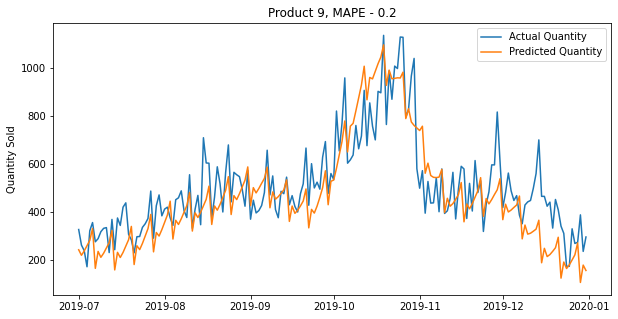

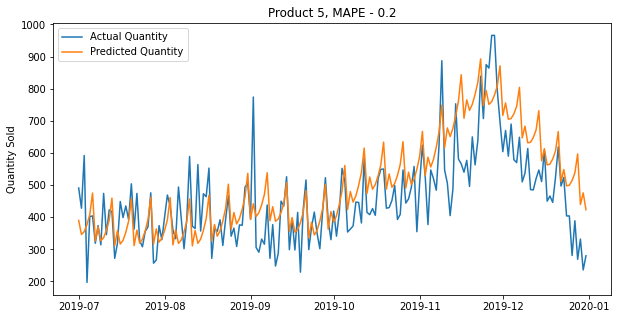

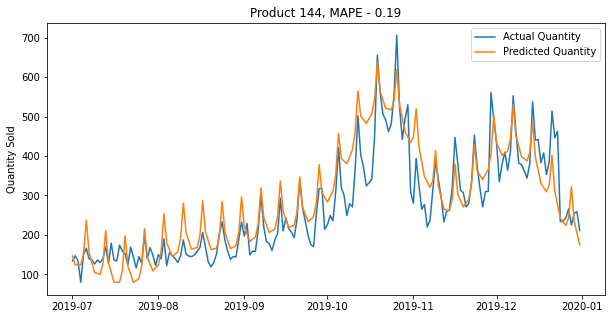

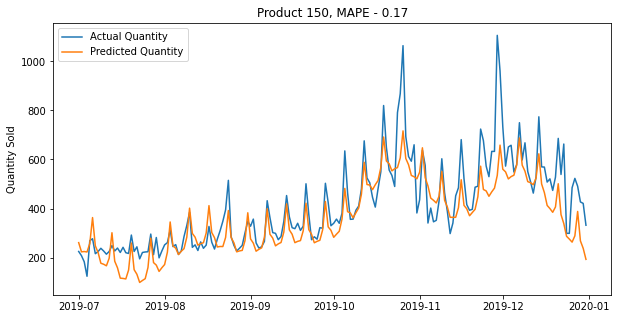

In [343]:

# Visualization of top performing models

import matplotlib
#pdf = matplotlib.backends.backend_pdf.PdfPages("./output.pdf")
for i in cleaned_sales_data_impute[cleaned_sales_data_impute.Product_Rank < 20].Product.unique():

    if(model_performance[model_performance.Product == i]['MAPE'].to_list().pop() < 0.20):
        plt.figure(figsize=(10, 5))
        #print(round(model_performance[model_performance.Product == i]['MAPE'].to_list().pop(), 2))
        performance = round(model_performance[model_performance.Product == i]['MAPE'].to_list().pop(), 2)
        plt.title("{}, MAPE - {}".format(i, performance))
        plt.plot(model_test_data[model_test_data.Product == i]['ds'], model_test_data[model_test_data.Product == i]['y'],label="Actual Quantity")
        plt.plot(model_test_data[model_test_data.Product == i]['ds'], model_test_data[model_test_data.Product == i]['yhat'], label = "Predicted Quantity")  
        plt.ylabel("Quantity Sold")
        plt.legend() 
        #pdf.savefig()
#pdf.close() 

    

In [279]:
def future_prediction(product_list, df):
    
    model_data = pd.DataFrame([])  
    mape_test = 0

    for i in product_list:
        temp_data = df[df['Product'] == i][["Date", "Quantity"]].rename({'Date':'ds', 'Quantity':'y'}, axis=1)
        #temp_test_data = test_df[test_df['Product'] == i][["ds", "y"]]
        prophet = Prophet()
        prophet.fit(temp_data)
        future_dates = prophet.make_future_dataframe(periods=91, freq = 'D')
        pred_prophet = prophet.predict(future_dates)
        model_data = model_data.append(pd.DataFrame({ 'Product' : i,
                                                        'ds': pred_prophet[pred_prophet.ds > temp_data.ds.max()]['ds'].to_list(), 
                                                        #'y' : temp_test_data['y'],
                                                        'yhat' :  pred_prophet[pred_prophet.ds > temp_data.ds.max()]['yhat'].to_list()                       
                                                                                         }))
                                                                                    

    return model_data




In [280]:
model_predictions = future_prediction(cleaned_sales_data_impute.Product.unique(), cleaned_sales_data_impute)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:prophet:Disabling daily seasonality. Run 

## Merging the prediction with Promotion data

In [281]:
predictions_3_months = model_predictions.copy()
predictions_3_months = predictions_3_months.rename({'ds':'Date', 'yhat':'Quantity'}, axis=1)
predictions_3_months = predictions_3_months.merge(product, on='Product', how = 'left')

In [282]:
# Resetting the promotion data format 
def expand_promotions(product_list, df):
    promortion_expand_data = []
    for i in product_list:
        temp_df = df[df.Product == i]
        s = pd.concat([pd.Series(r.Index, pd.date_range(r._2, r._3)) for r in temp_df.itertuples()])
        x = temp_df.join(pd.DataFrame({'Date':s.index}, index=s))
        #print(x)
        promortion_expand_data.append(x)
    promortion_expand_data = pd.concat(promortion_expand_data)
    
    return promortion_expand_data
promortion_expand_data =  expand_promotions(promotion.Product.unique(), promotion)



In [283]:
# Merge prediction data with promotion data
predictions_3_months = predictions_3_months.merge(promortion_expand_data, on=['Product', 'Date'], how='left')
predictions_3_months.drop(['Promotion start', 'Promotion end'], axis=1, inplace=True)


In [284]:
# Calculating retail price after adding promotion
predictions_3_months.rename({"Offer_Type": "OfferType"}, axis=1, inplace=True)
predictions_3_months.OfferType = predictions_3_months.OfferType.astype('str')
retail_price_after_promotion(predictions_3_months)

<ipython-input-269-f90150879dd4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Promo_UnitRetailPrice'][idx] = df['UnitRetailPrice'][idx]
<ipython-input-269-f90150879dd4>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Promo_UnitRetailPrice'][idx] = val
<ipython-input-269-f90150879dd4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Promo_UnitRetailPrice'][idx] = df['UnitRetailPrice'][idx] * (100-val)/100


In [285]:
# Setting quantity as int
predictions_3_months.Quantity = predictions_3_months.Quantity.apply(lambda x : round(x, 0))

# Calculating Sales of the product
predictions_3_months['Sales_of_Product'] = predictions_3_months['Quantity'] * predictions_3_months['Promo_UnitRetailPrice']
predictions_3_months['Sales_of_Product'] = predictions_3_months['Sales_of_Product'].apply(lambda x: round(x, 2))
predictions_3_months

,Product,Date,Quantity,Sub Category,Category,UnitRetailPrice,Offer,OfferType,Promo_UnitRetailPrice,Sales_of_Product
0,Product 9,2020-01-01,228.0,Sub Category 6,Category 3,6.99,NaN,nan,6.99,1593.72
1,Product 9,2020-01-02,246.0,Sub Category 6,Category 3,6.99,NaN,nan,6.99,1719.54
2,Product 9,2020-01-03,270.0,Sub Category 6,Category 3,6.99,NaN,nan,6.99,1887.30
3,Product 9,2020-01-04,326.0,Sub Category 6,Category 3,6.99,NaN,nan,6.99,2278.74
4,Product 9,2020-01-05,163.0,Sub Category 6,Category 3,6.99,NaN,nan,6.99,1139.37
...,...,...,...,...,...,...,...,...,...,...
12193,Product 178,2020-03-27,1.0,Sub Category 60,Category 21,9.95,NaN,nan,9.95,9.95
12194,Product 178,2020-03-28,1.0,Sub Category 60,Category 21,9.95,NaN,nan,9.95,9.95
12195,Product 178,2020-03-29,1.0,Sub Category 60,Category 21,9.95,NaN,nan,9.95,9.95
12196,Product 178,2020-03-30,1.0,Sub Category 60,Category 21,9.95,NaN,nan,9.95,9.95


## Result

In [286]:
predictions_3_months.to_csv("Sales_of_Product.csv")